In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
%matplotlib inline


# Camera calibration and Undistort

## Camera Calibration

In [2]:
def camera_calibration(images, nx, ny):
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].transpose().reshape(-1, 2)
    objpoints = []
    imgpoints = []
    img_size = (1280, 720)
    
    for frame in tqdm(images):
        img = cv2.imread(frame)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


## Undistort

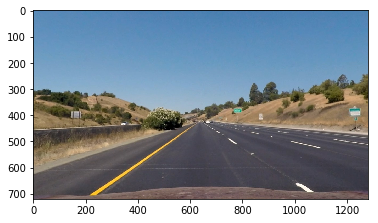

In [3]:
img = mpimg.imread("output_images/origin.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)
# cv2.imwrite("output_images/undist.jpg", cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))


# Perspective Transform(Chessboard)

In [4]:
def corners_unwarp(undist, nx, ny, mtx, dist):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0][0], corners[nx - 1][0], corners[-1][0], corners[-nx][0]])
        dst = np.float32([[100, 100], [1150,100], [1150, 650], [100, 650]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
        
    return warped, M

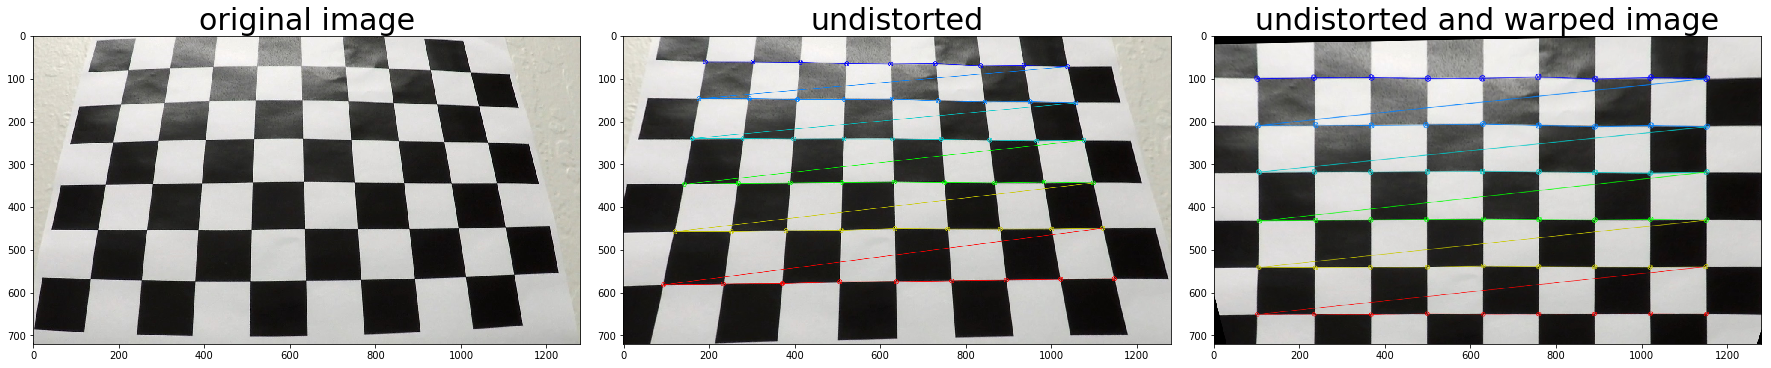

In [5]:
img = mpimg.imread("camera_cal/calibration3.jpg")
nx = 9
ny = 6
undist = cv2.undistort(img, mtx, dist, None, mtx)

top_down, perspective_M = corners_unwarp(undist, nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=30)
ax3.imshow(top_down)
ax3.set_title('undistorted and warped image', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

# ROI

(<matplotlib.image.AxesImage at 0x7f73a997ecf8>,
 <matplotlib.text.Text at 0x7f73a99d9da0>)

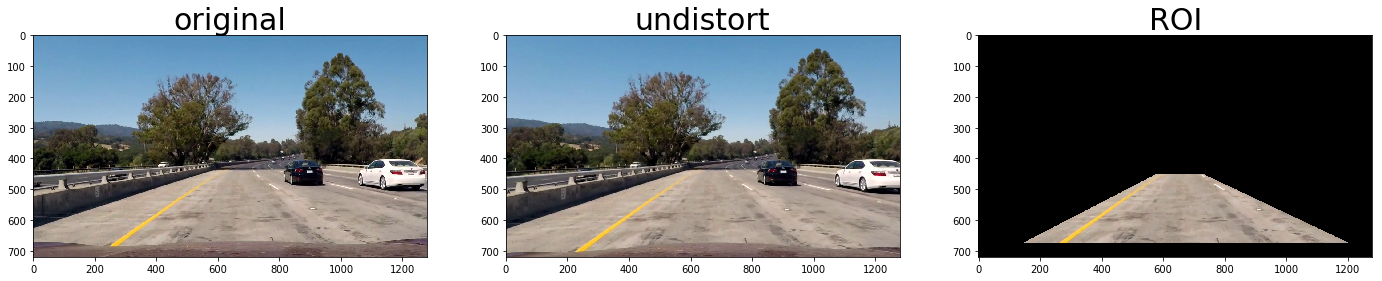

In [6]:
left_bottom = (150, 672)
left_top = (580, 450)
right_bottom = (1200, 672)
right_top = (730, 450)
roi_points = [[left_top, right_top, right_bottom, left_bottom]]

def region_of_interest(img, roi_points):
    mask = np.zeros_like(img)
    vertices = np.array(roi_points, dtype=np.int32)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread("project/2001.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)


f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
axs[1].imshow(undist), axs[1].set_title('undistort', fontsize=30)
axs[2].imshow(roi), axs[2].set_title('ROI', fontsize=30)

# Warp

(<matplotlib.image.AxesImage at 0x7f736e457320>,
 <matplotlib.text.Text at 0x7f736e4b4f28>)

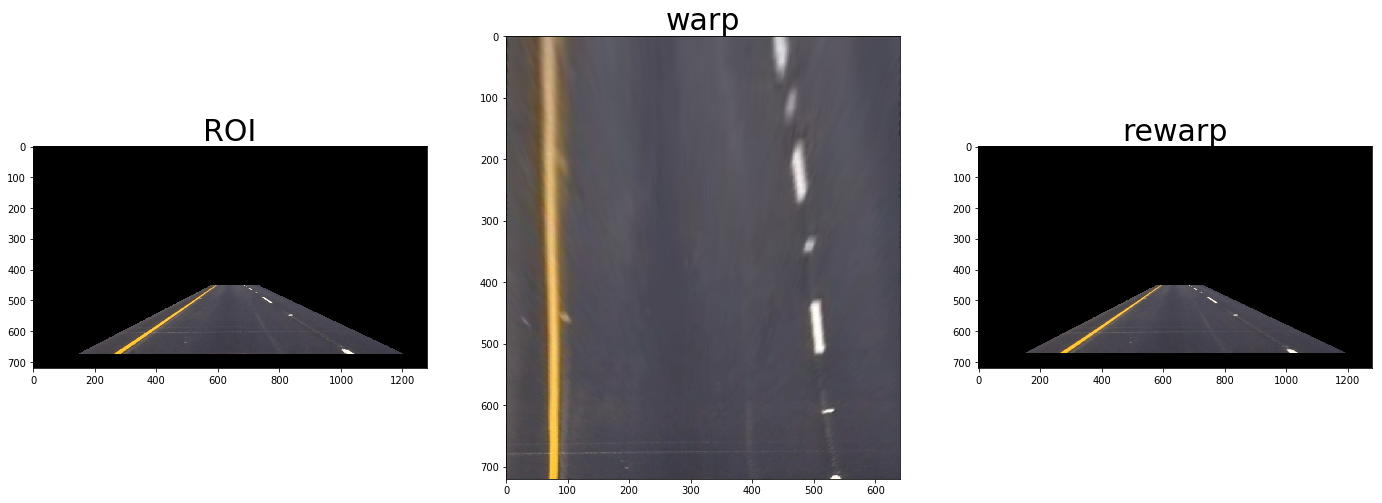

In [7]:
def warp(img, roi_points):
    src = np.float32(roi_points)
    dst = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (640, 720), flags=cv2.INTER_LINEAR)    
    return warped

def rewarp(img, roi_points):
    dst = np.float32(roi_points)
    src = np.float32([[0, 0], [640, 0], [640, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    rewarped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_LINEAR)
    return rewarped
    
img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
rewarped = rewarp(warped, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(roi, cmap='gray'), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('warp', fontsize=30)
axs[2].imshow(rewarped, cmap='gray'), axs[2].set_title('rewarp', fontsize=30)

# Tophat

(<matplotlib.image.AxesImage at 0x7f736d6201d0>,
 <matplotlib.text.Text at 0x7f736d679278>)

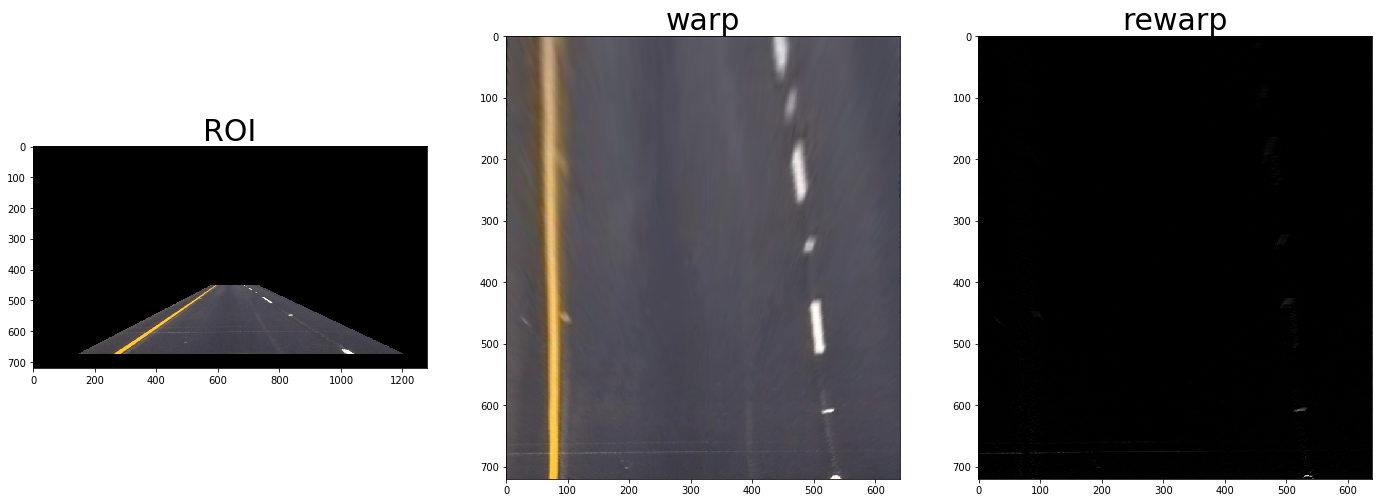

In [8]:
def top_hat(img, kernel):
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return tophat

img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
tophat = top_hat(gray, (9,9))

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(roi, cmap='gray'), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped, cmap='gray'), axs[1].set_title('warp', fontsize=30)
axs[2].imshow(tophat, cmap='gray'), axs[2].set_title('rewarp', fontsize=30)

# Binary

## 1 Sobel

(<matplotlib.image.AxesImage at 0x7f736d4aa198>,
 <matplotlib.text.Text at 0x7f736d501828>)

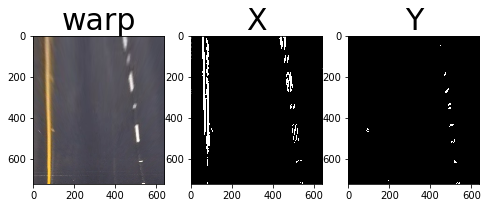

In [9]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    if (orient=='x'):
        sobel = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
#     binary = cv2.erode(binary, (3,3), iterations=1)
    return binary

img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
sxbinary = abs_sobel_thresh(warped, 'x', 9, (30, 100))
sybinary = abs_sobel_thresh(warped, 'y', 9, (30, 100))

f, axs = plt.subplots(1, 3, figsize=(8, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=30)
axs[1].imshow(sxbinary, cmap='gray'), axs[1].set_title('X', fontsize=30)
axs[2].imshow(sybinary, cmap='gray'), axs[2].set_title('Y', fontsize=30)

## 2 Magnitude

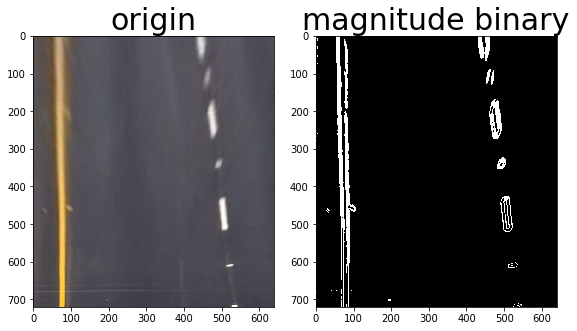

In [57]:
def mag_thresh(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary
    
img = mpimg.imread("test_images/s1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
mag_binary = mag_thresh(warped, 9, (30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('origin', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('magnitude binary', fontsize=30)
    

## 3 Direction

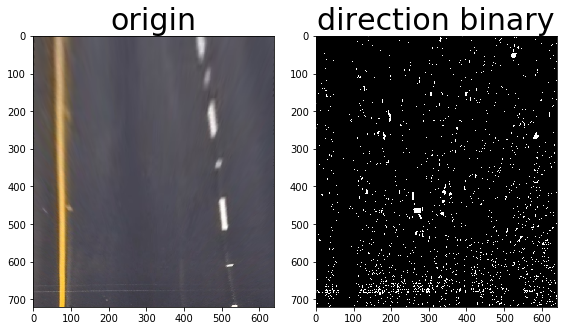

In [58]:
def dir_thresh(img, sobel_kernel, thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    sobelx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     scaled_gradir = np.uint8(np.pi * gradir / 2 * np.max(gradir)) 
#     why not normalized?
    binary = np.zeros_like(gradir)
    binary[(gradir >= thresh[0]) & (gradir <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
dir_binary = dir_thresh(warped, 15, (1.5, 2.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('origin', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('direction binary', fontsize=30)

## 4 Combine gradient
Now consider how to use various aspects of your gradient measurements(x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how you can use **thresholds of the x and y gradients** or **the overall gradient magnitude and direction** to focus on pixels that are likely to be part of the lane lines.

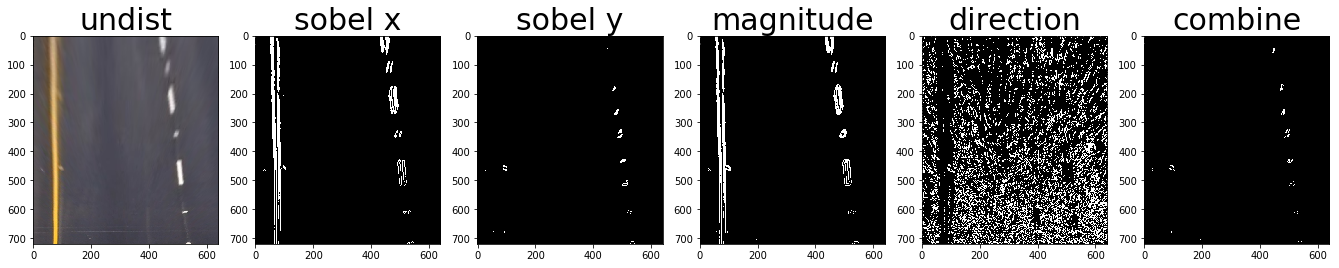

In [59]:
img = mpimg.imread("test_images/s1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
sx_binary = abs_sobel_thresh(warped, 'x', 9, (30, 100))
sy_binary = abs_sobel_thresh(warped, 'y', 9, (30, 100))
mag_binary = mag_thresh(warped, 9, (30, 100))
dir_binary = dir_thresh(warped, 15, (0.7, 1.3))
combined = np.zeros_like(dir_binary)
# threshold of x,y gradient or magnitude and direction
combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, axs = plt.subplots(1, 6, figsize=(18, 9))
axs[0].imshow(warped), axs[0].set_title('undist', fontsize=30)
axs[1].imshow(sx_binary, cmap='gray') ,axs[1].set_title('sobel x', fontsize=30)
axs[2].imshow(sy_binary, cmap='gray'), axs[2].set_title('sobel y', fontsize=30)
axs[3].imshow(mag_binary, cmap='gray'), axs[3].set_title('magnitude', fontsize=30)
axs[4].imshow(dir_binary, cmap='gray'), axs[4].set_title('direction', fontsize=30)
axs[5].imshow(combined, cmap='gray'), axs[5].set_title('combine', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

## 5 Color Space: RGB

(<matplotlib.image.AxesImage at 0x7f7351072208>,
 <matplotlib.text.Text at 0x7f7351046b70>)

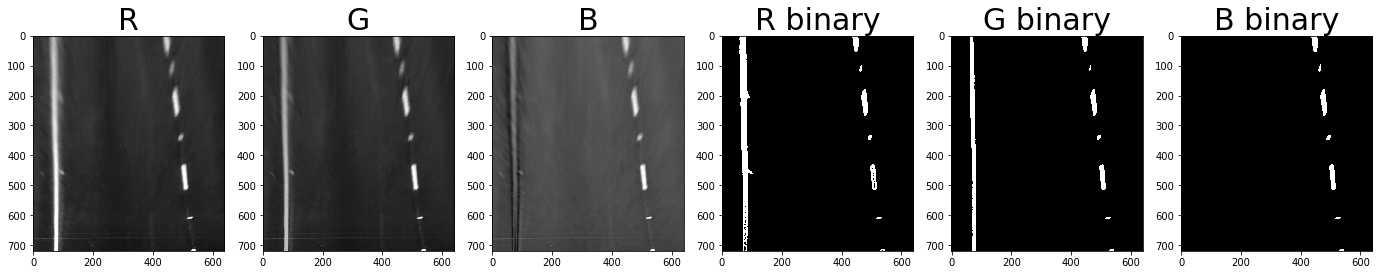

In [60]:
def rgb_thresh(img, channel, thresh):
    channel = img[:,:,channel]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel < thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
R = warped[:,:,0]
G = warped[:,:,1]
B = warped[:,:,2]
r_binary = rgb_thresh(warped, 0, (150, 255))
g_binary = rgb_thresh(warped, 1, (150, 255))
b_binary = rgb_thresh(warped, 2, (150, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(R, cmap='gray') ,axs[0].set_title('R', fontsize=30)
axs[1].imshow(G, cmap='gray'), axs[1].set_title('G', fontsize=30)
axs[2].imshow(B, cmap='gray'), axs[2].set_title('B', fontsize=30)
axs[3].imshow(r_binary, cmap='gray') ,axs[3].set_title('R binary', fontsize=30)
axs[4].imshow(g_binary, cmap='gray'), axs[4].set_title('G binary', fontsize=30)
axs[5].imshow(b_binary, cmap='gray'), axs[5].set_title('B binary', fontsize=30)

## 6 Color Space: HLS

(<matplotlib.image.AxesImage at 0x7f73510ec320>,
 <matplotlib.text.Text at 0x7f735146d6d8>)

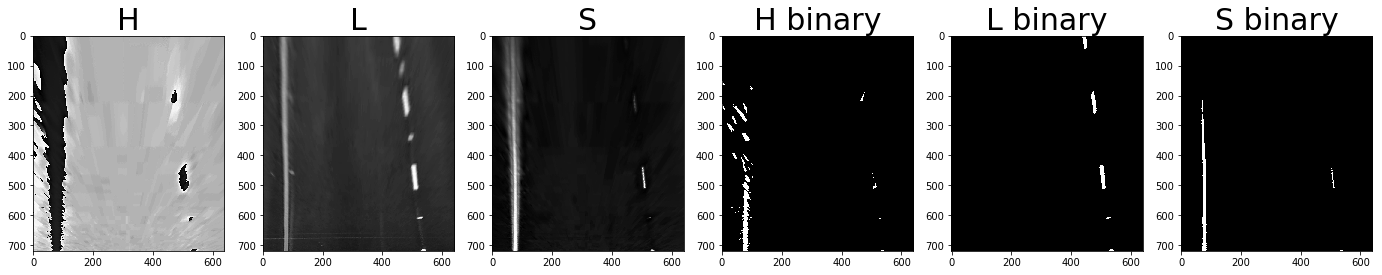

In [61]:
def hls_thresh(img, channel_number, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel_number]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
H_binary = hls_thresh(warped, 0, (19, 50))
L_binary = hls_thresh(warped, 1, (195, 255))
S_binary = hls_thresh(warped, 2, (150, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(H, cmap='gray') ,axs[0].set_title('H', fontsize=30)
axs[1].imshow(L, cmap='gray'), axs[1].set_title('L', fontsize=30)
axs[2].imshow(S, cmap='gray'), axs[2].set_title('S', fontsize=30)
axs[3].imshow(H_binary, cmap='gray') ,axs[3].set_title('H binary', fontsize=30)
axs[4].imshow(L_binary, cmap='gray'), axs[4].set_title('L binary', fontsize=30)
axs[5].imshow(S_binary, cmap='gray'), axs[5].set_title('S binary', fontsize=30)

## 7 Color Space: LAB

(<matplotlib.image.AxesImage at 0x7f734a7ac080>,
 <matplotlib.text.Text at 0x7f734a7819e8>)

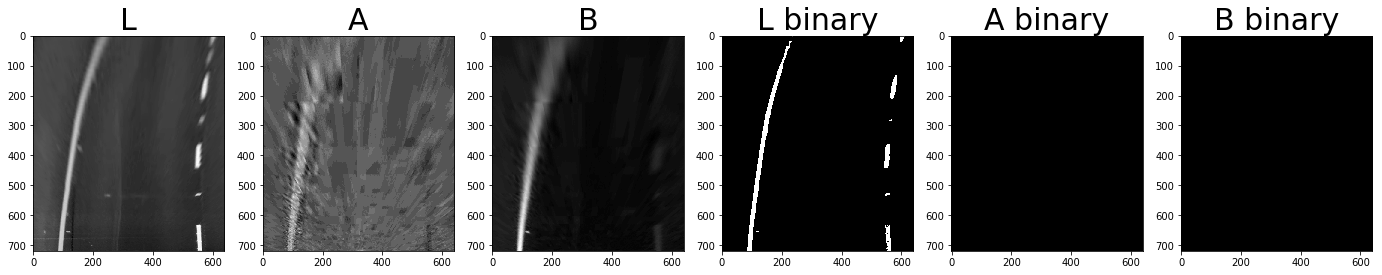

In [78]:
def lab_thresh(img, channel_number, thresh):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    channel = lab[:,:,channel_number]
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary

img = mpimg.imread("test_images/c3.jpg")   
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
lab = cv2.cvtColor(warped, cv2.COLOR_RGB2LAB)
L = lab[:,:,0]
A = lab[:,:,1]
B = lab[:,:,2]
l_binary = lab_thresh(warped, 0, (160, 250))
a_binary = lab_thresh(warped, 1, (10, 255))
b_binary = lab_thresh(warped, 2, (10, 255))

f, axs = plt.subplots(1, 6, figsize=(24, 9))
axs[0].imshow(L, cmap='gray') ,axs[0].set_title('L', fontsize=30)
axs[1].imshow(A, cmap='gray'), axs[1].set_title('A', fontsize=30)
axs[2].imshow(B, cmap='gray'), axs[2].set_title('B', fontsize=30)
axs[3].imshow(l_binary, cmap='gray') ,axs[3].set_title('L binary', fontsize=30)
axs[4].imshow(a_binary, cmap='gray'), axs[4].set_title('A binary', fontsize=30)
axs[5].imshow(b_binary, cmap='gray'), axs[5].set_title('B binary', fontsize=30)

## 8 Combine gradient and color

(<matplotlib.image.AxesImage at 0x7f73509c6208>,
 <matplotlib.text.Text at 0x7f7350a4c5f8>)

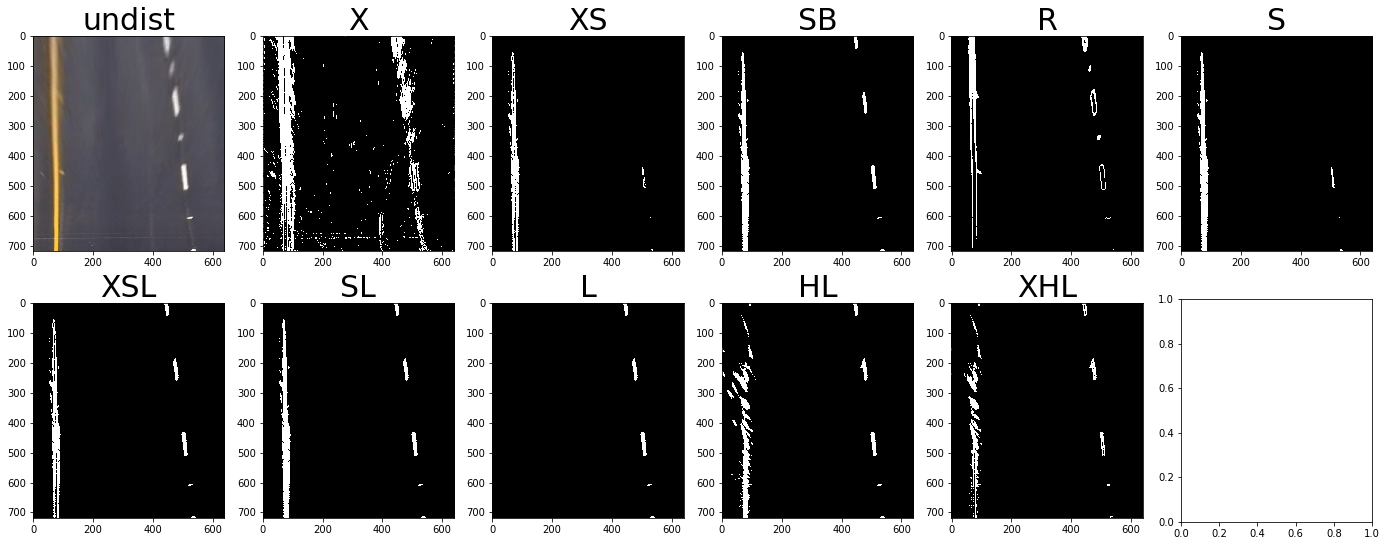

In [63]:
# combine sobel x and saturatioin
def xs_thresh(img, x_thresh, s_thresh):
    sxbinary = abs_sobel_thresh(img, 'x', 3, x_thresh)
#     sxbinary = cv2.erode(img, (5,5), iterations=1)
    s_binary = hls_thresh(img, 2, s_thresh)

    xs_binary = np.zeros_like(sxbinary)
    xs_binary[(sxbinary == 1) & (s_binary == 1)] = 1

    return xs_binary

# combine saturation or blue
def sb_thresh(img, s_thresh, b_thresh):    
    s_binary = hls_thresh(img, 2, s_thresh)
    b_binary = rgb_thresh(img, 2, b_thresh)
    sb_binary = np.zeros_like(sxbinary)
    sb_binary[(b_binary == 1) | (s_binary == 1)] = 1
    return sb_binary

def sl_thresh(img, s_thresh, l_thresh):
    l_binary = hls_thresh(img, 1, l_thresh)
    s_binary = hls_thresh(img, 2, s_thresh)
    
    sl_binary = np.zeros_like(s_binary)
    sl_binary[(s_binary == 1) | (l_binary == 1)] = 1
    
    return sl_binary

def xsl_thresh(img, x_thresh, s_thresh, l_thresh):
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    s_binary = hls_thresh(img, 2, s_thresh)

    xs_binary = np.zeros_like(sxbinary)
    xs_binary[(sxbinary == 1) & (s_binary == 1)] = 1
    
    l_binary = hls_thresh(img, 1, l_thresh)
    xsl_binary = np.zeros_like(xs_binary)
    xsl_binary[(xs_binary == 1) | (l_binary == 1)] = 1
    
    return xsl_binary

def hl_thresh(img, h_thresh, l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l > l_thresh[0]) & (l <= l_thresh[1])] = 1
    hl_binary = np.zeros_like(l)
    hl_binary[(h_binary == 1) | (l_binary == 1)] = 1
    return hl_binary

def xhl_thresh(img, x_thresh, h_thresh, l_thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    l = hls[:,:,1]
    h_binary = np.zeros_like(h)
    h_binary[(h > h_thresh[0]) & (h <= h_thresh[1])] = 1
    l_binary = np.zeros_like(l)
    l_binary[(l > l_thresh[0]) & (l <= l_thresh[1])] = 1
    hl_binary = np.zeros_like(l)
    hl_binary[(h_binary == 1) | (l_binary == 1)] = 1
    
    sxbinary = abs_sobel_thresh(img, 'x', 5, x_thresh)
    xhl_binary = np.zeros_like(sxbinary)
    xhl_binary[(hl_binary == 1) & (sxbinary == 1)] = 1
    
    return xhl_binary

img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
l_binary = hls_thresh(warped, 1, (195, 255))
x_binary = abs_sobel_thresh(warped, 'x', 5, (5, 100))
xs_binary = xs_thresh(warped, (3, 200), (100, 255))
sb_binary = sb_thresh(warped, (100, 255), (200, 255))
r_binary = rgb_thresh(warped, 0, (150, 220))
sl_binary = sl_thresh(warped, (100, 255), (195, 255))
s_binary = hls_thresh(warped, 2, (100, 255))
xsl_binary = xsl_thresh(warped, (5, 200), (100, 255), (195, 255))
hl_binary = hl_thresh(warped, (18, 50), (195, 255))
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))

f, axs = plt.subplots(2, 6, figsize=(24, 9))
axs[0,0].imshow(warped), axs[0,0].set_title('undist', fontsize=30)
axs[0,1].imshow(x_binary, cmap='gray'), axs[0,1].set_title('X', fontsize=30)
axs[0,2].imshow(xs_binary, cmap='gray'), axs[0,2].set_title('XS', fontsize=30)
axs[0,3].imshow(sb_binary, cmap='gray'), axs[0,3].set_title('SB', fontsize=30)
axs[0,4].imshow(r_binary, cmap='gray'), axs[0,4].set_title('R', fontsize=30)
axs[0,5].imshow(s_binary, cmap='gray'), axs[0,5].set_title('S', fontsize=30)
axs[1,0].imshow(xsl_binary, cmap='gray'), axs[1,0].set_title('XSL', fontsize=30)
axs[1,1].imshow(sl_binary, cmap='gray'), axs[1,1].set_title('SL', fontsize=30)
axs[1,2].imshow(l_binary, cmap='gray'), axs[1,2].set_title('L', fontsize=30)
axs[1,3].imshow(hl_binary, cmap='gray'), axs[1,3].set_title('HL', fontsize=30)
axs[1,4].imshow(xhl_binary, cmap='gray'), axs[1,4].set_title('XHL', fontsize=30)

# Histogram

([<matplotlib.lines.Line2D at 0x7f7352ca6978>],
 <matplotlib.text.Text at 0x7f7352c80898>)

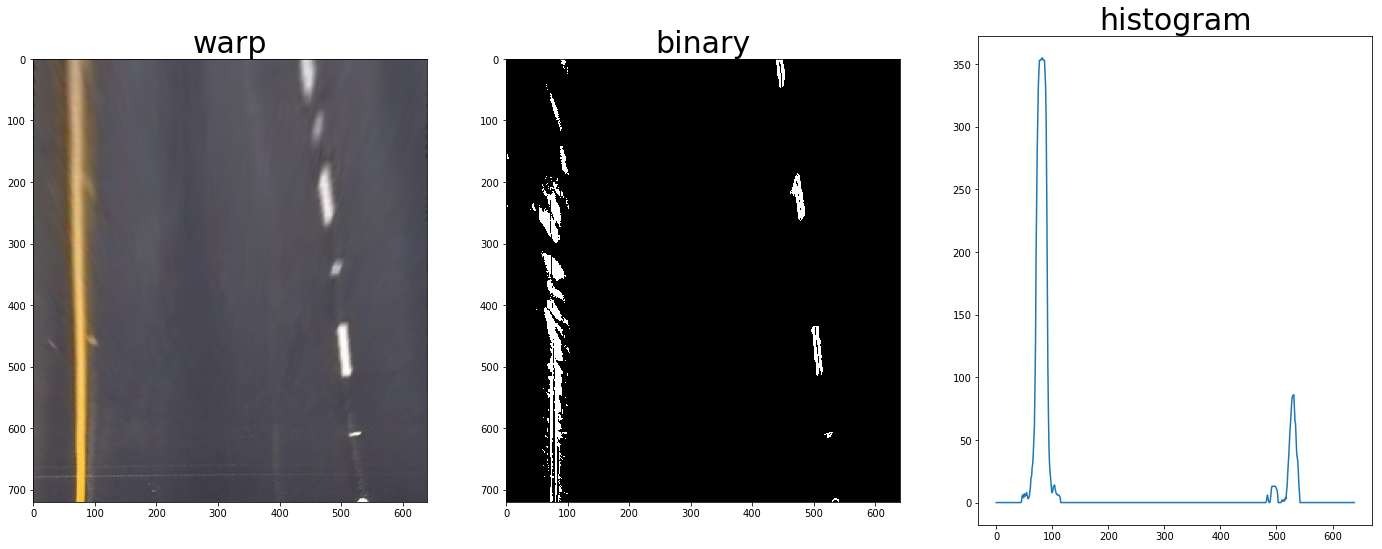

In [17]:
img = mpimg.imread("output_images/origin.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
histogram = np.sum(hl_binary[xhl_binary.shape[0]//2:,:], axis=0)


f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(warped, cmap='gray'), axs[0].set_title('warp', fontsize=30)
axs[1].imshow(xhl_binary, cmap='gray'), axs[1].set_title('binary', fontsize=30)
axs[2].plot(histogram), axs[2].set_title('histogram', fontsize=30)

# Sliding Windows

(<matplotlib.image.AxesImage at 0x7f734a632828>,
 <matplotlib.text.Text at 0x7f734a619c88>)

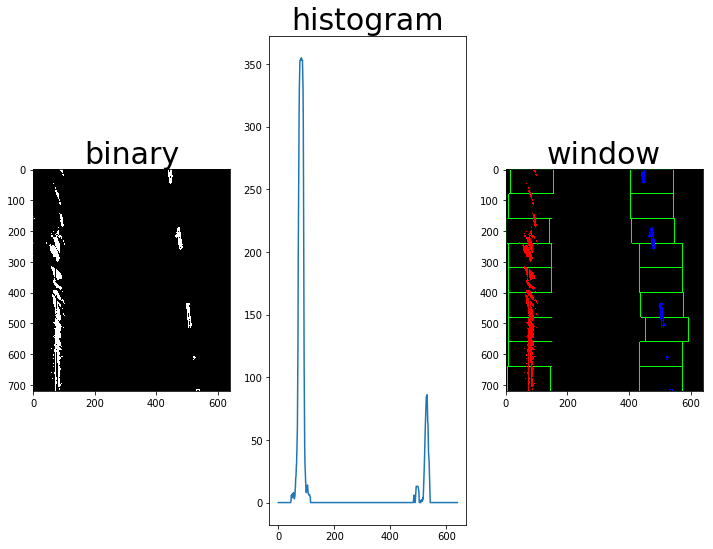

In [79]:
def nonzero(warped):
    # identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

def sliding_windows(warped):
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    nonzerox, nonzeroy = nonzero(warped)
    
    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint

    # the number of sliding windows
    nwindows = 9
    # set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    
    # current positions to be updated for each window
    left_current = left_base
    right_current = right_base
    # set with width of the windows +/- margin
    margin = 70
    # set minimum number of pixels found to recenter window
    minpix = 50
    # create empty lists to receive left and right lane pixel indices
    left_inds = []
    right_inds = []

    # step through the windows one by one
    for window in range(nwindows):
        # identify window boundaries in x and y (and right and left)
        win_low = warped.shape[0] - (window + 1) * window_height
        win_high = warped.shape[0]- window * window_height
        win_left_left = left_current - margin
        win_left_right = left_current + margin
        win_right_left = right_current - margin
        win_right_right = right_current + margin
        # draw the windows on the visualization image
        cv2.rectangle(out, (win_left_left, win_low), (win_left_right, win_high), (0, 255, 0), 2)
        cv2.rectangle(out, (win_right_left, win_low), (win_right_right, win_high), (0, 255, 0), 2)
        # identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_left_left) & (nonzerox < win_left_right)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_low) & (nonzeroy < win_high) & (nonzerox >= win_right_left) & (nonzerox < win_right_right)).nonzero()[0]
        # append these indices in this window to the list of all windows
        left_inds.append(good_left_inds)
        right_inds.append(good_right_inds)
        # if you found > minpix pixels, recenter next window on theri mean position
        if len(good_left_inds) > minpix:
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
                   
    # concatenate all the arrays of indices
    left_inds = np.concatenate(left_inds)  
    right_inds = np.concatenate(right_inds)
    
    # draw left and right lane lines     
    out[nonzeroy[left_inds], nonzerox[left_inds]] = [255, 0, 0]
    out[nonzeroy[right_inds], nonzerox[right_inds]] = [0, 0, 255]
    
    return [left_inds, right_inds]

img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
out = np.dstack((xhl_binary, xhl_binary, xhl_binary)) ** 255
indices = sliding_windows(xhl_binary)
        
f, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(xhl_binary, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('window', fontsize=30)

# Polynomial Fit

[array([  5.13237036e-05,  -3.62874990e-02,   8.29469538e+01]), array([ -3.04049101e-05,   1.47461302e-01,   4.43025411e+02])]


(<matplotlib.image.AxesImage at 0x7f734a526b38>,
 <matplotlib.text.Text at 0x7f734a5aabe0>)

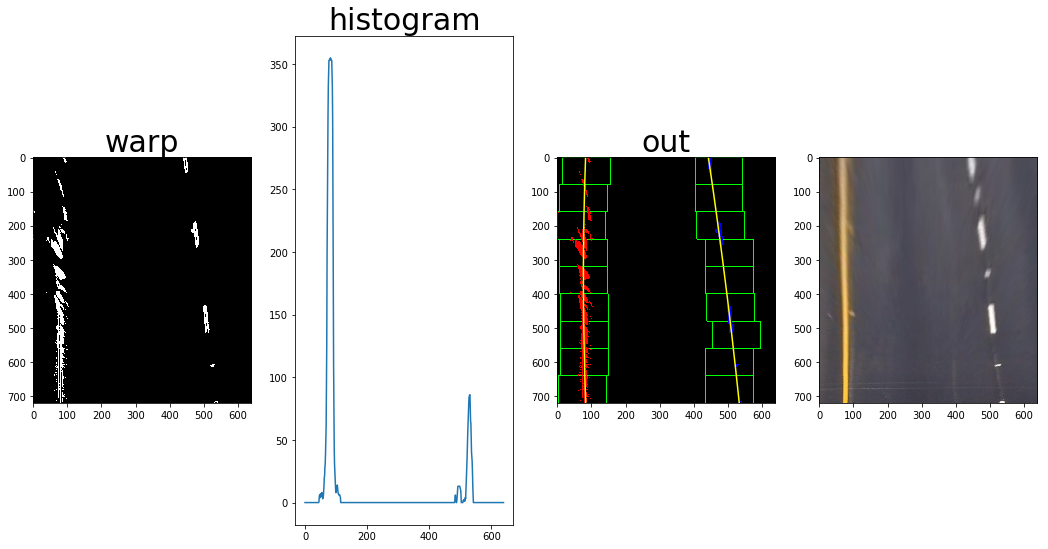

In [80]:
def fit_polynomial(warped, indices, polynomial):
    # divide left and right indices
    left_inds = indices[0]
    right_inds = indices[1]
    
    if (len(left_inds)==0 | len(right_inds)==0):
        return polynomial
    
    nonzerox, nonzeroy = nonzero(warped)
    
    # extract x and y of lane line pixel by indices
    leftx = nonzerox[left_inds]
    lefty = nonzeroy[left_inds]
    rightx = nonzerox[right_inds]
    righty = nonzeroy[right_inds]

    # fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if((polynomial != []) & (left_fit[0] * right_fit[0] < 0.)):
        if(np.absolute(left_fit[1] - polynomial[0][1]) > 0.1):
            left_fit[0] = right_fit[0]
            left_fit[1] = right_fit[1]
            left_fit[2] = right_fit[2] - 450
        if(np.absolute(right_fit[1] - polynomial[1][1]) > 0.1):
            right_fit[0] = left_fit[0]
            right_fit[1] = left_fit[1]
            right_fit[2] = left_fit[2] + 450
    
#     print(left_fit, polynomial)
#     if((polynomial != []) & (np.absolute(left_fit[2] - polynomial[0][2]) > 60)):
#         left_fit = polynomial[0]
    
    return [left_fit, right_fit]

# generate x and y values for plotting
def calculate_lane(polynomial):
    left_poly = polynomial[0]
    right_poly = polynomial[1]
    ploty = np.linspace(0, 719, 720)
    left_fitx = left_poly[0] * ploty ** 2 + left_poly[1] * ploty + left_poly[2] 
    right_fitx = right_poly[0] * ploty ** 2 + right_poly[1] * ploty + right_poly[2]
    return [left_fitx, right_fitx]
    
img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (4, 100), (18, 50), (195, 255))
out = np.dstack((xhl_binary, xhl_binary, xhl_binary)) ** 255
indices = sliding_windows(xhl_binary)
polynomial = fit_polynomial(xhl_binary, indices, [])
print(polynomial)
laneline = calculate_lane(polynomial)
ploty = np.linspace(0, 719, 720)

f, axs = plt.subplots(1, 4, figsize=(18, 9))
axs[0].imshow(xhl_binary, cmap='gray'), axs[0].set_title('binary', fontsize=30)
axs[1].plot(histogram), axs[1].set_title('histogram', fontsize=30)
axs[2].imshow(out), axs[2].set_title('out', fontsize=30)
axs[2].plot(laneline[0], ploty, color='yellow'), axs[2].plot(laneline[1], ploty, color='yellow')
axs[3].imshow(warped), axs[0].set_title('warp', fontsize=30)

# Tuning Windows
Now I know where the lines are and have a fit. In the next frame of video I don't need to do a blind search again, but instead I can just search in a margin around the previous line positio.

[array([  4.87647593e-05,  -3.31736462e-02,   8.21621188e+01]), array([ -3.06755351e-05,   1.47534269e-01,   4.43043874e+02])]


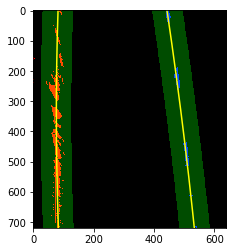

In [81]:
# tuning windows around the sliding windows or previous tuning windows
def tuning_windows(polynomial, warped_binary):
    left_poly = polynomial[0]
    right_poly = polynomial[1]
    ploty = np.linspace(0, 719, 720)
    nonzerox, nonzeroy = nonzero(warped_binary)  
    margin = 100

    # using pervious fit of polynomial to perdict the position of indices of lane line
    left_pre = left_poly[0] * nonzeroy ** 2 + left_poly[1] * nonzeroy + left_poly[2]
    right_pre = right_poly[0] * nonzeroy ** 2 + right_poly[1] * nonzeroy + right_poly[2]
    
    # find indices position in warp between prediction +/- margin
    left_inds = ((nonzerox > left_pre - margin) & (nonzerox < left_pre + margin))
    right_inds = ((nonzerox > right_pre - margin) & (nonzerox < right_pre + margin))
    
    return [left_inds, right_inds]

def tuning_draw(laneline, indices, warped_binary):
    left_fitx = laneline[0]
    right_fitx = laneline[1]
    ploty = np.linspace(0, 719, 720)
    nonzerox, nonzeroy = nonzero(warped_binary)  
    # create an image to draw on and an image to show the selection window
    out = np.dstack((warped_binary, warped_binary, warped_binary)) ** 255
    window = np.zeros_like(out)

    margin = 50
    # generate a polygon to illustrate the search window area and recast the x and y points into usable format for cv2.fillPoly()
    left_window1 = np.array([np.transpose(np.vstack([laneline[0] - margin, ploty]))])
    left_window2 = np.array([np.flipud(np.transpose(np.vstack([laneline[0] + margin, ploty])))])
    left_pts = np.hstack((left_window1, left_window2))
    right_window1 = np.array([np.transpose(np.vstack([laneline[1] - margin, ploty]))])
    right_window2 = np.array([np.flipud(np.transpose(np.vstack([laneline[1] + margin, ploty])))])
    right_pts = np.hstack((right_window1, right_window2))

    # color in left and right line pixels
    out[nonzeroy[indices[0]], nonzerox[indices[0]]] = [255, 0, 0]
    out[nonzeroy[indices[1]], nonzerox[indices[1]]] = [0, 0, 255]

    # draw the lane onto the warped blank image
    cv2.fillPoly(window, np.int_([left_pts]), (0, 255, 0))
    cv2.fillPoly(window, np.int_([right_pts]), (0, 255, 0))
    result = cv2.addWeighted(out, 1, window, 0.3, 0)
    
    return result


# the next frame of the video 
img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
indices = tuning_windows(polynomial, xhl_binary)
polynomial_new = fit_polynomial(xhl_binary, indices, [])
print(polynomial_new)
laneline = calculate_lane(polynomial_new)
result = tuning_draw(laneline, indices, xhl_binary)


plt.imshow(result)
plt.plot(laneline[0], ploty, color='yellow')
plt.plot(laneline[1], ploty, color='yellow')

# Curvature
The radius of curvature at any point *x* of the function $x=f(y)$ is given as follows:
$$
R = \frac{[1 + (dx/dy)^2]^{3/2}}{|d^2x/dy^2|}   
$$
The first and second derivatiove are:
$$
dx/dy = 2Ay + B; d^2x/dy^2 = 2A
$$
The equation for radius of curvature becomes:
$$
R = \frac{[1 + (2Ay + B)^2]^{3/2}}{|2A|}  
$$

(1557.4977030600135, 1559.5606354587785)


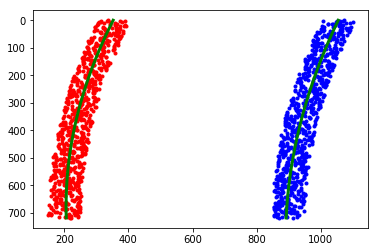

In [21]:
# generate some fake data to represent lane0line pixels
ploty = np.linspace(0, 719, num=720) # to cover some y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# for each y position generate random x position with +/- 50 pix
leftx = np.array([200 + quadratic_coeff * y ** 2 + np.random.randint(-50, high=51) for y in ploty])
rightx = np.array([900 + quadratic_coeff * y ** 2 + np.random.randint(-50, high=51) for y in ploty])

# reverse to match top-to-bottom in y
leftx = leftx[::-1]
rightx = rightx[::-1]

# fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
right_fit = np.polyfit(ploty, rightx, 2)

# calculate x for draw
left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]


def curvature_pixel(left_fit, right_fit, y_eval):
    # the radius of curvature corresponding to the bottom of the image
    left_curcerad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curcerad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    return left_curcerad, right_curcerad

print(curvature_pixel(left_fit, right_fit, 720))

# plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [22]:
# conversions in x and y from pixels space to meters
def curvature_meter(polynomial, ym, xm, y_eval):
    left_fit = polynomial[0]
    right_fit = polynomial[1]
    
    # pixel function to meter function
    l_A = left_fit[0] * xm / (ym ** 2)
    l_B = left_fit[1] * xm / ym
    
    # pixel function to meter function
    r_A = right_fit[0] * xm / (ym ** 2)
    r_B = right_fit[1] * xm / ym

    # calculate the new radius of curvature
    left_curcerad = ((1 + (2 * l_A * y_eval * ym + l_B) ** 2) ** 1.5) / np.absolute(2 * l_A)
    right_curcerad = ((1 + (2 * r_A * y_eval * ym + r_B) ** 2) ** 1.5) / np.absolute(2 * r_A)
    return left_curcerad, right_curcerad

left_curcerad, right_curcerad = curvature_meter([left_fit, right_fit], 30 / 720, 3.7 / 500, 720)
print(left_curcerad, 'm', right_curcerad, 'm')

364.979884351 m 456.920494705 m


# Rewarp

[array([  5.62704776e-05,  -4.20807447e-02,   8.47039592e+01]), array([ -3.06755351e-05,   1.47534269e-01,   4.43043874e+02])]


(<matplotlib.image.AxesImage at 0x7f734a1e3550>,
 <matplotlib.text.Text at 0x7f734a239eb8>)

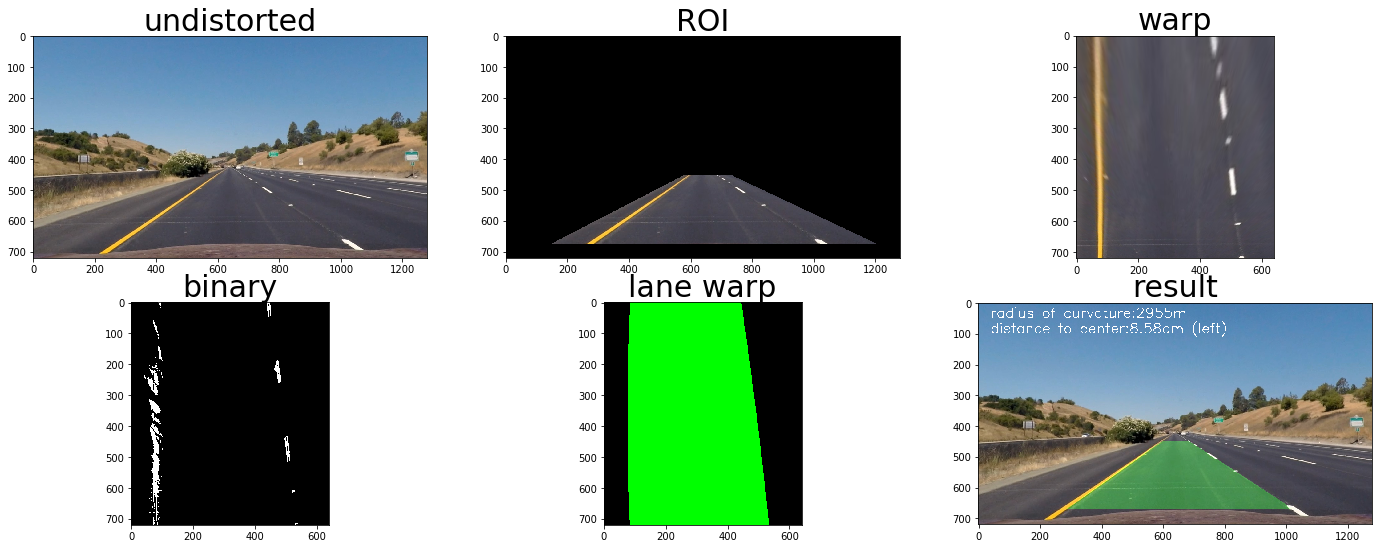

In [82]:
def warp_lane(warped, laneline):
    # create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    lane_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, 719, 720)
    left_pts = np.array([np.transpose(np.vstack([laneline[0], ploty]))])
    right_pts = np.array([np.flipud(np.transpose(np.vstack([laneline[1], ploty])))])
    pts = np.hstack((left_pts, right_pts))

    # draw the lane onto the warped blank image
    cv2.fillPoly(lane_warp, np.int_([pts]), (0, 255, 0))
    
    return lane_warp

def curvature_distance(laneline, polynomial):
    left_curcerad, right_curcerad = curvature_meter(polynomial, 30 / 720, 3.7 / 500, 720)
    curvature = int((left_curcerad + right_curcerad) / 2)
    distance = round(((laneline[0][-1] + laneline[1][-1]) / 2 - 320) * 3.7 / 5, 2)
    
    return curvature, distance

def draw_result(undist, lane_warp, roi_points, curvature, distance):
    # warp the blank back to original image space using inverse perspective matrix
    rewarped = rewarp(lane_warp, roi_points)
    result = cv2.addWeighted(undist, 1, rewarped, 0.3, 0)
    result = cv2.putText(result, 'radius of curvature:' + str(curvature) + 'm', (40, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    if (distance > 0):
        result = cv2.putText(result, 'distance to center:' + str(distance) + 'cm ' + '(right)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    else:
        result = cv2.putText(result, 'distance to center:' + str(-distance) + 'cm ' + '(left)', (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
    
    return result

img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(undist, roi_points)
xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
# sl_binary = sl_thresh(warped, (100, 255), (200, 255))
indices = sliding_windows(xhl_binary)
polynomial = fit_polynomial(xhl_binary, indices, [])
print(polynomial)
laneline = calculate_lane(polynomial)
curvature, distance = curvature_distance(laneline, polynomial)
lane_warp = warp_lane(xhl_binary, laneline)
result = draw_result(undist, lane_warp, roi_points, curvature, distance)


f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0,0].imshow(undist), axs[0,0].set_title('undistorted', fontsize=30)
axs[0,1].imshow(roi), axs[0,1].set_title('ROI', fontsize=30)
axs[0,2].imshow(warped), axs[0,2].set_title('warp', fontsize=30)
axs[1,0].imshow(xhl_binary, cmap='gray'), axs[1,0].set_title('binary', fontsize=30)
axs[1,1].imshow(lane_warp), axs[1,1].set_title('lane warp', fontsize=30)
axs[1,2].imshow(result), axs[1,2].set_title('result', fontsize=30)

# Pipeline

[array([  5.32288495e-05,  -3.86351522e-02,   8.37660670e+01]), array([ -3.06755351e-05,   1.47534269e-01,   4.43043874e+02])]
[array([  4.87647593e-05,  -3.31736462e-02,   8.21621188e+01]), array([ -3.06755351e-05,   1.47534269e-01,   4.43043874e+02])]


(<matplotlib.image.AxesImage at 0x7f734a0f5278>,
 <matplotlib.text.Text at 0x7f734a0819e8>)

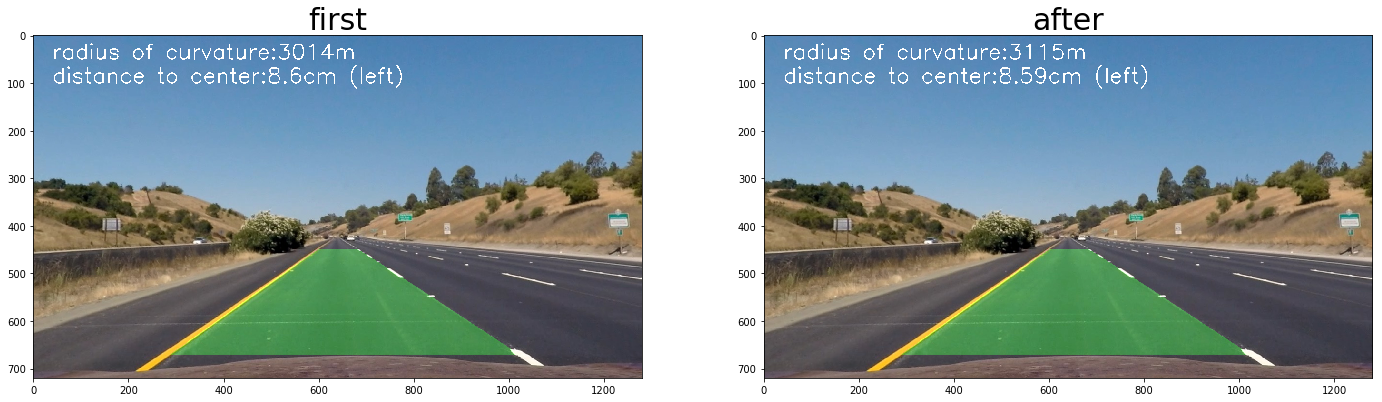

In [83]:
def process_sliding(img, mtx, dist, polynomial):  
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    roi = region_of_interest(undist, roi_points)
    warped = warp(roi, roi_points)
    xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
    indices = sliding_windows(xhl_binary)
    polynomial_new = fit_polynomial(xhl_binary, indices, polynomial)
    laneline = calculate_lane(polynomial_new)
    curvature, distance = curvature_distance(laneline, polynomial_new)
    lane_warp = warp_lane(xhl_binary, laneline)
    result = draw_result(undist, lane_warp, roi_points, curvature, distance)
    
    return result, polynomial_new

def process_tuning(img, mtx, dist, polynomial):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    roi = region_of_interest(undist, roi_points)
    warped = warp(roi, roi_points)
    xhl_binary = xhl_thresh(warped, (5, 100), (18, 50), (195, 255))
    indices = tuning_windows(polynomial, xhl_binary)
    polynomial_new = fit_polynomial(xhl_binary, indices, polynomial)
    laneline = calculate_lane(polynomial_new)
    curvature, distance = curvature_distance(laneline, polynomial_new)
    lane_warp = warp_lane(xhl_binary, laneline)
    result = draw_result(undist, lane_warp, roi_points, curvature, distance)
    
    return result, polynomial_new
    
result1, polynomial = process_sliding(mpimg.imread("test_images/s1.jpg"), mtx, dist, [])
print(polynomial)
result2, polynomial = process_tuning(mpimg.imread("test_images/s1.jpg"), mtx, dist, polynomial)
print(polynomial)
# result2 = cv2.cvtColor(result2, cv2.COLOR_RGB2BGR)
# cv2.imwrite("output_images/s2.jpg", result2)

f, axs = plt.subplots(1, 2, figsize=(24, 9))
axs[0].imshow(result1), axs[0].set_title('first', fontsize=30)
axs[1].imshow(result2), axs[1].set_title('after', fontsize=30)

# Video

In [56]:
images = glob.glob("project/*.jpg")
result, polynomial = process_sliding(mpimg.imread("project/1000.jpg"), mtx, dist, [])
for i in tqdm(range(0,len(images))): 
    if (i % 5 == 0):
        result, polynomial = process_sliding(mpimg.imread("project/%d.jpg" % (1000 + i)), mtx, dist, polynomial)
    else:
        result, polynomial = process_tuning(mpimg.imread("project/%d.jpg" % (1000 + i)), mtx, dist, polynomial)
        
    result = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
    cv2.imwrite("project_result/%d.jpg" % (i + 1000), result)

True